# Impacts associated with drought: Kenya

This script is using a sample from the ERA5--Drought data set from the European Centre for Medium-range Weather Forecasts (ECMWF) and plots a timeseries for a subset of the dataset. 
The output of this notebook is published as Figure 7 in 
> Keune, J., F. Di Giuseppe, C. Barnard, and F. Wetterhall (XXXX): \textbf{ERA5--Drought: Global drought indicators based on ECMWF reanalysis}, submitted to Scientific Data. 

## Setup and Settings

#### Load libraries

In [1]:
import os 
import sys
import math
import datetime as dt
import pandas as pd
import netCDF4 as nc4
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
import fiona
import regionmask
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as matplotdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import string
from dateutil import relativedelta

#### Some helpful functions

In [2]:
EARTHRADIUS = 6371  # earth radius [km]
def calculate_gridarea(lats_centr, res, nlon):

    lats1 = (lats_centr + (res / 2)) * np.pi / 180  # np.sin requires radians
    lats2 = (lats_centr - (res / 2)) * np.pi / 180
    areas = (
        (np.pi / 180) * (EARTHRADIUS ** 2) * np.abs(np.sin(lats1) - np.sin(lats2)) * res
    )

    ## overwrite any areas of 0 (at the poles) with np.NaN to prevent problems
    areas[np.where(areas == 0.0)] = np.NaN  
    # return array of dimension nlat x nlon
    area_2d = np.swapaxes(np.tile(areas, (nlon, 1)), 0, 1)
    return area_2d

#### General settings

In [3]:
ipath = "/ec/vol/centaur/nejk/drought_monitor/"

### Landmask

In [4]:
# binary land mask
lfile      = f"{ipath}/landmask_era5_global.nc"
lmask      = xr.open_dataset(lfile)['lsm']
lmask      = lmask.where( lmask.values == 1 ) # set 0s to nan
# land fraction
lffile     = f"{ipath}/landmask_era5_global_frac.nc"
lmask_frac = xr.open_dataset(lffile)['var172']

In [5]:
area_2d = calculate_gridarea(lmask.lat, res=abs(lmask.lat[1]-lmask.lat[0]), nlon=len(lmask.lon))*lmask[0,:,:]
area_2d = xr.DataArray(area_2d, coords={'lat': lmask.lat,'lon': lmask.lon}, dims=["lat", "lon"])
#area_2d.plot()

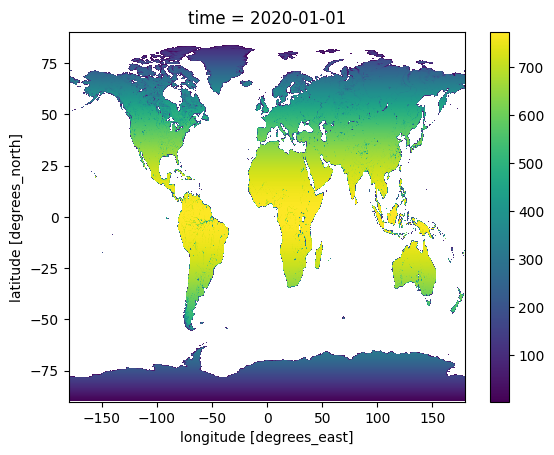

In [6]:
# adjust using land fraction
area_2d_adj = area_2d * lmask_frac
area_2d_adj = area_2d_adj.where( area_2d_adj.values != 0 ) # set 0s to nan
area_2d_adj.plot()

## Drought indices

### Read SPI

In [7]:
spi12 = xr.open_mfdataset(os.path.join(ipath, "spi/spi12/SPI12_gamma_global_era5_moda_ref1991to2020_*12.nc"))
print(spi12)

<xarray.Dataset> Size: 698MB
Dimensions:  (time: 84, lon: 1440, lat: 721)
Coordinates:
  * time     (time) datetime64[ns] 672B 1940-12-01T06:00:00 ... 2023-12-01T06...
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    SPI12    (time, lat, lon) float64 698MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       DRYFALL v0.1
    institution:  ECMWF
    title:        SPI12
    description:  Drought Index: Standardized Drought Index calculated accord...
    history:      Thu Feb 15 09:50:03 2024: cdo -selyear,1940 -selmon,12 /scr...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


### Read SPEI

In [8]:
spei12 = xr.open_mfdataset(os.path.join(ipath, "spei/spei12/SPEI12_genlogistic_global_era5_moda_ref1991to2020_*12.nc"))
print(spei12)

<xarray.Dataset> Size: 698MB
Dimensions:  (time: 84, lon: 1440, lat: 721)
Coordinates:
  * time     (time) datetime64[ns] 672B 1940-12-01T06:00:00 ... 2023-12-01T06...
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    SPEI12   (time, lat, lon) float64 698MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       DRYFALL v0.1
    institution:  ECMWF
    title:        SPEI12
    description:  Drought Index: Standardized Drought Index calculated accord...
    history:      Thu Feb 15 13:46:41 2024: cdo -selyear,1940 -selmon,12 /scr...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


### Mask data

#### Barren mask

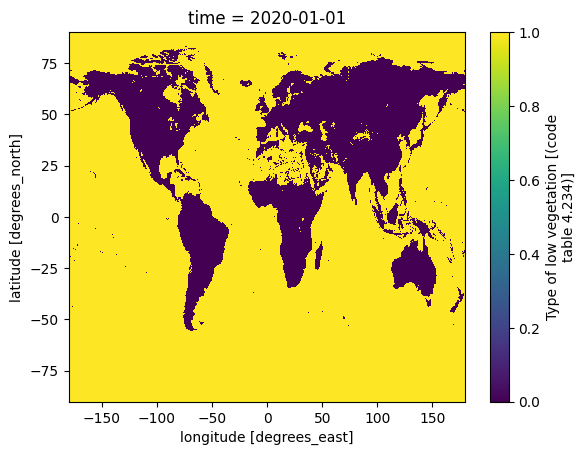

In [9]:
vfile = f"{ipath}/barren_mask.nc"
bmask = xr.open_dataset(vfile)['barren_mask']
bmask_3d = bmask.reindex_like(spei12, method="nearest")
bmask.plot()

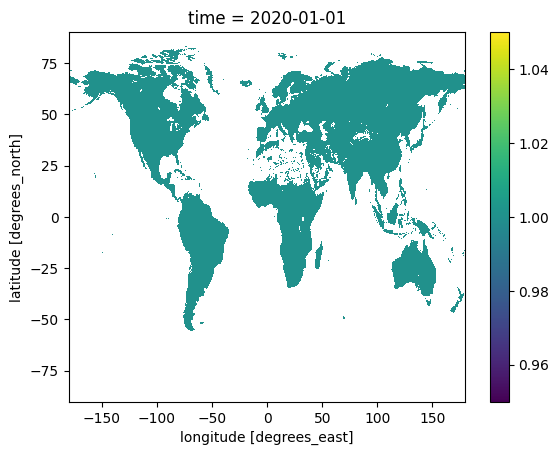

In [10]:
vlmask = xr.where( (bmask == 0) & (lmask == 1), 1, np.nan)
vlmask.plot()
lmask_3d  = lmask.reindex_like(spi12, method="nearest")
vlmask_3d = vlmask.reindex_like(spi12, method="nearest")

#### Reliability data | SPI

In [11]:
sfile = f"{ipath}/spi/spi12/parameter/SPI12_gamma_global_era5_moda_ref1991to2020_params_updated.nc"
params_spi12 = xr.open_dataset(sfile).sel(time="1900-12-01")
sig_spi12 = xr.where(params_spi12['significance'] == 1, 1, np.nan)
p0_spi12  = xr.where(params_spi12['pzero'] <= 0.1, 1, np.nan)

In [12]:
#spi12_masked = xr.where( (vlmask_3d == 1) & (sig_spi12 == 1), spi12, np.nan)
spi12_masked = xr.where( (vlmask_3d == 1) & (sig_spi12 == 1) & (p0_spi12 == 1), spi12, -9999) # set masked values to -9999 (shown grey)
spi12_masked = xr.where( np.isnan(lmask_3d), np.nan, spi12_masked) # set ocean to nan (shown white)

In [13]:
#spi12_masked.isel(time=82)['SPI12'].plot(vmax=3, vmin=-3)

#### Reliability data | SPEI

In [14]:
sfile = f"{ipath}/spei/spei12/parameter/SPEI12_genlogistic_global_era5_moda_ref1991to2020_params_updated.nc"
params_spei12 = xr.open_dataset(sfile).sel(time="1900-12-01")
sig_spei12 = xr.where(params_spei12['significance'] == 1, 1, np.nan)

In [15]:
spei12_masked = xr.where( (vlmask_3d == 1) & (sig_spei12 == 1), spei12, -9999) # set masked values to -9999 (shown grey)
spei12_masked = xr.where( np.isnan(lmask_3d), np.nan, spei12_masked) # set ocean to nan (shown white)

## Kenya

### Define region

ADMIN regions were downloaded from:
https://www.naturalearthdata.com/downloads/

In [16]:
adminid     = "KEN"

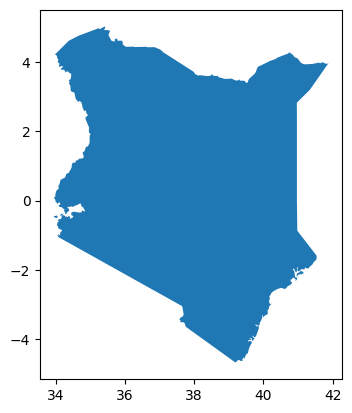

In [17]:
geoshp = gpd.read_file('./data/metadata/ne_10m_admin_0_countries_lakes')
adminshpa = geoshp.loc[ (geoshp.SOV_A3 == adminid), 'geometry' ]
adminshpa.plot()
adminshp = adminshpa.unary_union
adminshpa=adminshpa.to_crs('epsg:4326')

In [18]:
lon1 = math.floor(adminshpa.bounds.minx.values[0])
lon2 = math.ceil(adminshpa.bounds.maxx.values[0])
lat1 = math.floor(adminshpa.bounds.miny.values[0])
lat2 = math.ceil(adminshpa.bounds.maxy.values[0])
print(f"Bounding box: lats {lat1} to {lat2}, lons {lon1} to {lon2}")

Bounding box: lats -5 to 6, lons 33 to 42


In [19]:
# get mask of grid points in nuts region
adminmask = regionmask.mask_geopandas(adminshpa, spei12.lon, spei12.lat)
adminmask_xr = xr.DataArray(adminmask, coords={'lat': spei12.lat, 'lon': spei12.lon}, dims=["lat", "lon"])
adminmask_xr = adminmask_xr.where( adminmask_xr.values == 16, np.nan) # to get nan in all other cases, 16 otherwise
adminmask_xr = adminmask_xr.where( np.isnan(adminmask_xr.values), 1) # to set the 0 from regionmask to 1
adminmask_3d_xr = adminmask_xr.expand_dims(dim={"time": spei12.time}, axis=0)

### Area in drought

In [20]:
# calculate area in drought
area_3d_adj = area_2d_adj.reindex_like(spi12, method="nearest")
aid_spi = {}
aid_spei = {}

window = 12
swindow=f"w{window}"
aid_spi[swindow] = {}
aid_spei[swindow] = {}

for severity in ['moderate','severe','extreme','any']:
        
    if severity == "mild":
        thresh_min = -1
        thresh_max = 0
    if severity == "moderate":
        thresh_min = -1.5
        thresh_max = -1
    if severity == "severe":
        thresh_min = -2
        thresh_max = -1.5
    if severity == "extreme":
        thresh_min = -999
        thresh_max = -2
    if severity == "any":
        thresh_min = -999
        thresh_max = -1

    rspi   = spi12_masked * adminmask_3d_xr
    dmask  = xr.where((rspi > thresh_min) & (rspi <= thresh_max) & (rspi != -9999), 1, np.nan)
    tmp    = 100 * (dmask*area_3d_adj).sum(dim=["lat", "lon"]) / (adminmask_3d_xr*area_3d_adj).sum(dim=["lat", "lon"])
    aid_spi[swindow][severity] = tmp.to_pandas() 

    del(tmp, dmask)

    rspei  = spei12_masked * adminmask_3d_xr
    dmask  = xr.where((rspei > thresh_min) & (rspei <= thresh_max) & (rspei != -9999), 1, np.nan)
    tmp    = 100 * (dmask*area_3d_adj).sum(dim=["lat", "lon"]) / (adminmask_3d_xr*area_3d_adj).sum(dim=["lat", "lon"])
    aid_spei[swindow][severity] = tmp.to_pandas()

    del(tmp, dmask)

### Plot timeseries of area in drought

In [21]:
mylevels     = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000]
mycollisthex = ['#bebebe','#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']

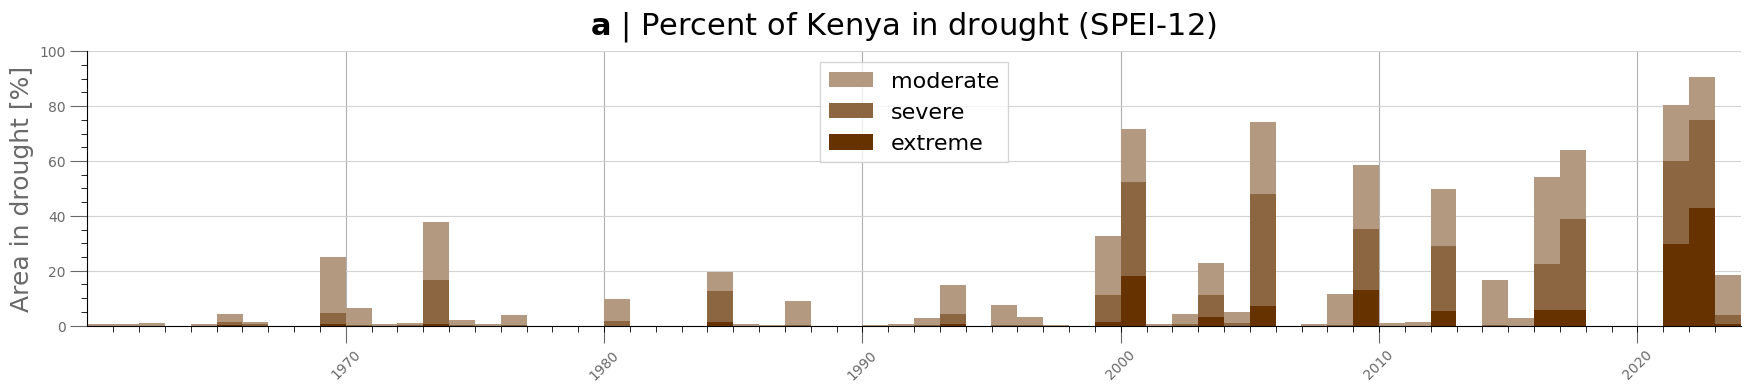

In [22]:
fig, ax1 = plt.subplots(1,1, figsize=(18,4))
title1 = r"$\bf{" + f"{string.ascii_lowercase[0]}" + "}$"
fig.suptitle(f"{title1} | Percent of Kenya in drought (SPEI-{window})", fontsize=22)
fig.tight_layout(pad=3.75)
fig.subplots_adjust(top=0.875)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

severities = ['extreme','severe','moderate']
pidata2 = aid_spei[f'w{window}']['extreme']['SPEI12']
pidata3 = aid_spei[f'w{window}']['severe']['SPEI12']
pidata4 = aid_spei[f'w{window}']['moderate']['SPEI12']
apidata = pd.concat([pidata2, pidata3, pidata4], axis=1)
apidata.index = apidata.index.shift(-(window-1), freq="MS") # shift datetimeindex to get start date
apidata = apidata.iloc[apidata.index.year>=1960]
bottom = np.zeros(len(apidata.index))
for i in range(len(apidata.columns)):
    p = ax1.bar(apidata.index, apidata.iloc[:,i], facecolor=mycollisthex[i+1], 
                alpha=1, 
                width=relativedelta.relativedelta(months=window), 
                label=severities[i], 
                bottom=bottom,
                align='edge')
    bottom += apidata.iloc[:,i]
ax1.set_ylabel("Area in drought [%]", size=18)
ax1.legend(ncol=1, loc='upper center', fancybox=False, shadow=False, reverse=True)
ax1.margins(x=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', colors='dimgrey')
ax1.xaxis.label.set_color('dimgrey')
ax1.yaxis.label.set_color('dimgrey')
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.tick_params(which='minor', length=4)
ax1.tick_params(which='major', length=12)
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='lightgray', linestyle='solid') #dashed
ax1.set_ylim([0,100])
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
plt.savefig("figures/Figure7a_Kenya_timeseries.pdf", dpi=300, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.show()

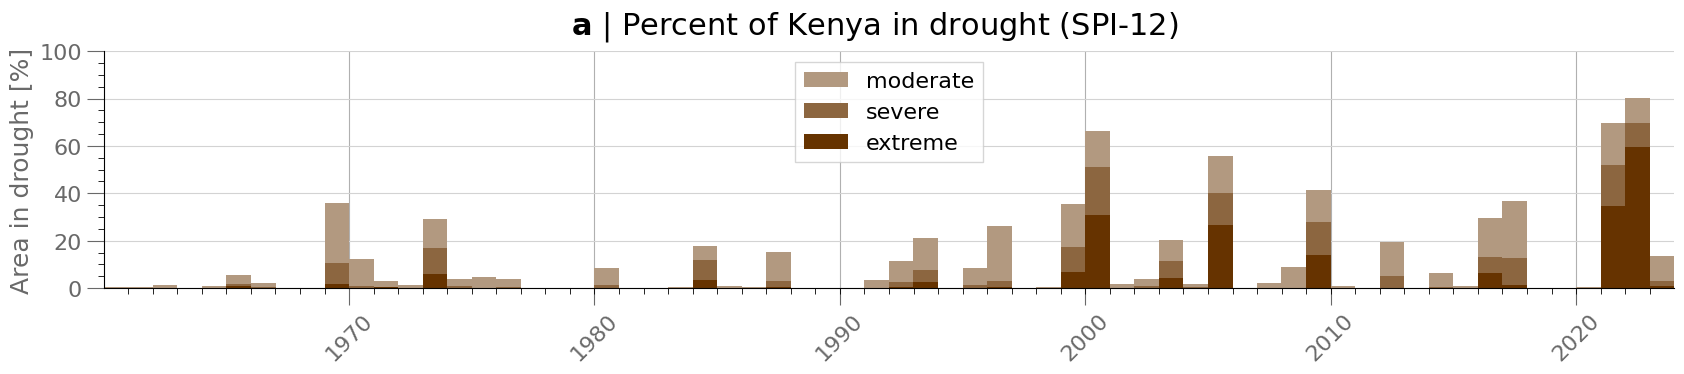

In [23]:
fig, ax1 = plt.subplots(1,1, figsize=(18,4))
title1 = r"$\bf{" + f"{string.ascii_lowercase[0]}" + "}$"
fig.suptitle(f"{title1} | Percent of Kenya in drought (SPI-{window})", fontsize=22)
fig.tight_layout(pad=3.75)
fig.subplots_adjust(top=0.875)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

severities = ['extreme','severe','moderate']
pidata2 = aid_spi[f'w{window}']['extreme']['SPI12']
pidata3 = aid_spi[f'w{window}']['severe']['SPI12']
pidata4 = aid_spi[f'w{window}']['moderate']['SPI12']
apidata = pd.concat([pidata2, pidata3, pidata4], axis=1)
apidata.index = apidata.index.shift(-(window-1), freq="MS") # shift datetimeindex to get start date
apidata = apidata.iloc[apidata.index.year>=1960]
bottom = np.zeros(len(apidata.index))
for i in range(len(apidata.columns)):
    p = ax1.bar(apidata.index, apidata.iloc[:,i], facecolor=mycollisthex[i+1], 
                alpha=1, 
                width=relativedelta.relativedelta(months=window), 
                label=severities[i], 
                bottom=bottom,
                align='edge')
    bottom += apidata.iloc[:,i]
ax1.set_ylabel("Area in drought [%]", size=18)
ax1.legend(ncol=1, loc='upper center', fancybox=False, shadow=False, reverse=True)
ax1.margins(x=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', colors='dimgrey')
ax1.xaxis.label.set_color('dimgrey')
ax1.yaxis.label.set_color('dimgrey')
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.tick_params(which='minor', length=4)
ax1.tick_params(which='major', length=12)
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='lightgray', linestyle='solid') #dashed
ax1.set_ylim([0,100])
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
plt.savefig("figures/Figure7b_Kenya_timeseries.pdf", dpi=300, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.show()

## EM-DAT impacts

### Settings

In [24]:
# disaster and country selection
disaster_category = "Disaster Type"
selected_disaster = "Drought"
continent         = "Africa"
country_name      = "Kenya"

emfile = "./data/em_dat/emdat_"+selected_disaster.lower()+"_"+continent.lower()+".xls"

# date range
syyyy = 1960
eyyyy = 2023

# What should be plotted?; increasing the list may require color adjustments below
selected_social_impacts   = ['Total Deaths','Total Affected']
selected_economic_impacts = ['Total Damages, Adjusted (1000 USD)']

# colors
cmap  = plt.get_cmap('tab20c',20).colors
cols  = [cmap[4],cmap[5],cmap[6],cmap[7]]
cmap2 = plt.get_cmap('Dark2',8).colors
impact_cols_soc  = [cmap2[0],cmap2[2]]
impact_cols_eco  = [cmap2[5]]

# extracted impacts
social_impacts   = ['No. Homeless', 'No. Injured', 'No. Affected', 'Total Deaths', 'Total Affected']
economic_impacts = ['Total Damage, Adjusted (1000 USD)'] # there's more here,

### Useful functions 

In [25]:
def fix_column_names(df):
    # remove special characters from column names
    df.columns = df.columns.str.replace("\'000 US\$", '1000 USD', regex=True)

def fix_nan2int(df):
    # handle additional columns that are supposedly integer but have missing values individually; due to issues with NaN in pandas: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html
    for icolumn in ['Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless', 'Total Affected',
                    'Reconstruction Costs (1000 USD)', 'Reconstruction Costs, Adjusted (1000 USD)', 'Insured Damage (1000 USD)',
                    'Insured Damage, Adjusted (1000 USD)', 'Total Damage (1000 USD)', 'Total Damage, Adjusted (1000 USD)']:
        df[icolumn] = df[icolumn].fillna(0)
        df[icolumn] = df[icolumn].astype(int)
        
def fill_unknown_duration(df):
    # set nan to 1 and 12 for start and end month, respectively
    df['Start Month']   = df['Start Month'].fillna(1)
    df['Start Month']   = df['Start Month'].astype(int)
    df['End Month']     = df['End Month'].fillna(12)
    df['End Month']     = df['End Month'].astype(int)

def convert2datetime(df):
    # add leading zero to all months
    df['Start Month']   = df['Start Month'].astype(str).str.zfill(2)
    df['End Month']     = df['End Month'].astype(str).str.zfill(2)
    # create datetime object for start and end dates
    df['start_date']    = df[ ['Start Year','Start Month'] ].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    df['start_date']    = pd.to_datetime(df['start_date'])
    df['end_date']      = df[ ['End Year','End Month'] ].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    df['end_date']      = pd.to_datetime(df['end_date'])

def adjust_dates(df, log_unknown=True):
    # handle unknown start/end months: log unknowns and then set start=1 and end=12
    if log_unknown:
        df['start_unknown'] = df['Start Month'].isna().astype(int)
        df['end_unknown'] = df['End Month'].isna().astype(int)
    # set nan to 1 and 12 for start and end month, respectively   
    fill_unknown_duration(df)
    # convert to datetime objects
    convert2datetime(df)

def calculate_duration_months(df):
    duration_months  = []
    for i in range(len(df['start_date'])):
        duration_months.append( relativedelta.relativedelta(df['end_date'][i], df['start_date'][i]).years * 12 +
                                relativedelta.relativedelta(df['end_date'][i], df['start_date'][i]).months + 1 ) # adding one month, because always working with first day
    df['duration_months'] = duration_months

def df2ts(df, colnames, colname_start='start_date', colname_end='end_date', fill_value=0, **kwargs):
    ts_df = pd.DataFrame({'time': pd.date_range(df[colname_start].min(), df[colname_end].max(), **kwargs)})
    df_ts = ts_df.merge(df, how='left', left_on='time', right_on=colname_start).fillna(method='pad')
    df_ts.loc[(df_ts.time < df_ts[colname_start]) | (df_ts.time > df_ts[colname_end]), colnames] = fill_value
    # issue if one (short) event is defined within a longer event; then the value of the short event is used for the remaining long event...
    return df_ts

def list_of_unique_values(df, colnames):
    uvals = pd.concat([df[col] for col in colnames]).dropna().unique().tolist()
    return uvals

def legend_without_duplicate_labels(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), **kwargs)

### Read EM-DAT data from xlsx

In [26]:
#emdata = pd.read_excel(emfile, skiprows=6, header=0, na_values=['none'], 
#                       dtype={'Year': int, 'Start Year': int, 'End Year': int, 'Country': str, 'ISO': str, 'Region': str, 'Continent': str, 'Location': str, 'Associated Dis': str, 'Associated Dis2': str})
emdata = pd.read_excel(emfile, skiprows=0, header=0, na_values=['none'], 
                       dtype={'Year': int, 'Start Year': int, 'End Year': int, 'Country': str, 'ISO': str, 'Region': str, 'Continent': str, 'Location': str, 'Associated Dis': str, 'Associated Dis2': str})

# remove special characters from column names
fix_column_names(emdata) 

# handle additional columns that are supposedly integer but have missing values individually; due to issues with NaN in pandas: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html
fix_nan2int(emdata)

# handle unknown start/end months: log unknowns and convert start and end dates to datetime objects
# TO DO: add Start Day and End Day...
adjust_dates(emdata, log_unknown=True)

# estimate duration
calculate_duration_months(emdata)

# drop uninteresting columns
#emdata = emdata.drop(['Dis No', 'Seq', 'Glide', 'Adm Level'], axis=1) #emdata = emdata.drop(['Dis No', 'Seq', 'Glide', 'Adm Level','Admin1 Code','Admin2 Code'], axis=1)
#emdata = emdata.drop(['Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Disaster Group', 'Disaster Subgroup', 'Event Name'], axis=1) 

In [27]:
emdata.head()

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Total Damage, Adjusted (1000 USD)",CPI,Admin Units,Entry Date,Last Update,start_unknown,end_unknown,start_date,end_date,duration_months
0,1900-9002-CPV,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,CPV,...,0,2.730451,NaN,2006-12-01,2023-09-25,1,1,1900-01-01,1900-12-01,12
1,1903-9001-NER,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,NER,...,0,2.948887,NaN,2006-02-13,2023-09-25,1,1,1903-01-01,1903-12-01,12
2,1906-9025-NER,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,NER,...,0,2.948887,NaN,2006-02-13,2023-09-25,1,1,1906-01-01,1907-12-01,24
3,1910-9006-BFA,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,BFA,...,0,3.058105,NaN,2006-02-13,2023-09-25,1,1,1910-01-01,1914-12-01,60
4,1910-9006-CPV,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,CPV,...,0,3.058105,NaN,2006-02-13,2023-09-25,1,1,1910-01-01,1914-12-01,60


In [28]:
# extract specific event category for specific country, and adjust time frame
country_events = emdata[ (emdata[disaster_category]==selected_disaster) & (emdata['Country']==country_name) & (emdata['Start Year']>=syyyy) & (emdata['End Year']<=eyyyy) ]
print(country_events)
print("Number of "+str(selected_disaster.lower())+" events in "+str(country_name)+" between "+str(syyyy)+" and "+str(eyyyy)+": " +str(country_events.shape[0]))

            DisNo. Historic Classification Key Disaster Group  \
28   1965-9038-KEN      Yes    nat-cli-dro-dro        Natural   
53   1971-9004-KEN      Yes    nat-cli-dro-dro        Natural   
72   1979-9177-KEN      Yes    nat-cli-dro-dro        Natural   
109  1983-9060-KEN      Yes    nat-cli-dro-dro        Natural   
154  1991-9224-KEN      Yes    nat-cli-dro-dro        Natural   
162  1994-9422-KEN      Yes    nat-cli-dro-dro        Natural   
170  1996-9326-KEN      Yes    nat-cli-dro-dro        Natural   
190  1999-9388-KEN      Yes    nat-cli-dro-dro        Natural   
225  2004-9288-KEN       No    nat-cli-dro-dro        Natural   
238  2005-9719-KEN       No    nat-cli-dro-dro        Natural   
252  2008-9302-KEN       No    nat-cli-dro-dro        Natural   
267  2010-9082-KEN       No    nat-cli-dro-dro        Natural   
282  2011-9663-KEN       No    nat-cli-dro-dro        Natural   
294  2014-9404-KEN       No    nat-cli-dro-dro        Natural   
311  2016-9452-KEN       

In [50]:
# Co-occuring disasters
dis         = list_of_unique_values(country_events, ['Associated Types'])
print("The following disasters co-occurred during "+str(selected_disaster.lower())+" events: ")
print(*dis, sep=', ')
dis_markers = ['o','*','v','D', '*', '^', 'X']
dis_sizes   = [12] * len(dis)
dis_loc     = range(len(dis))
dis_cols    = [cols[2]] * len(dis)
### TO DO: separate by "|" (Crop failure|Food shortage)

The following disasters co-occurred during drought events: 
Food shortage, Crop failure|Food shortage, Famine


### Plot

/etc/ecmwf/ssd/ssd1/tmpdirs/nejk.34892036/ipykernel_1337280/3551543619.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts = ts_df.merge(df, how='left', left_on='time', right_on=colname_start).fillna(method='pad')


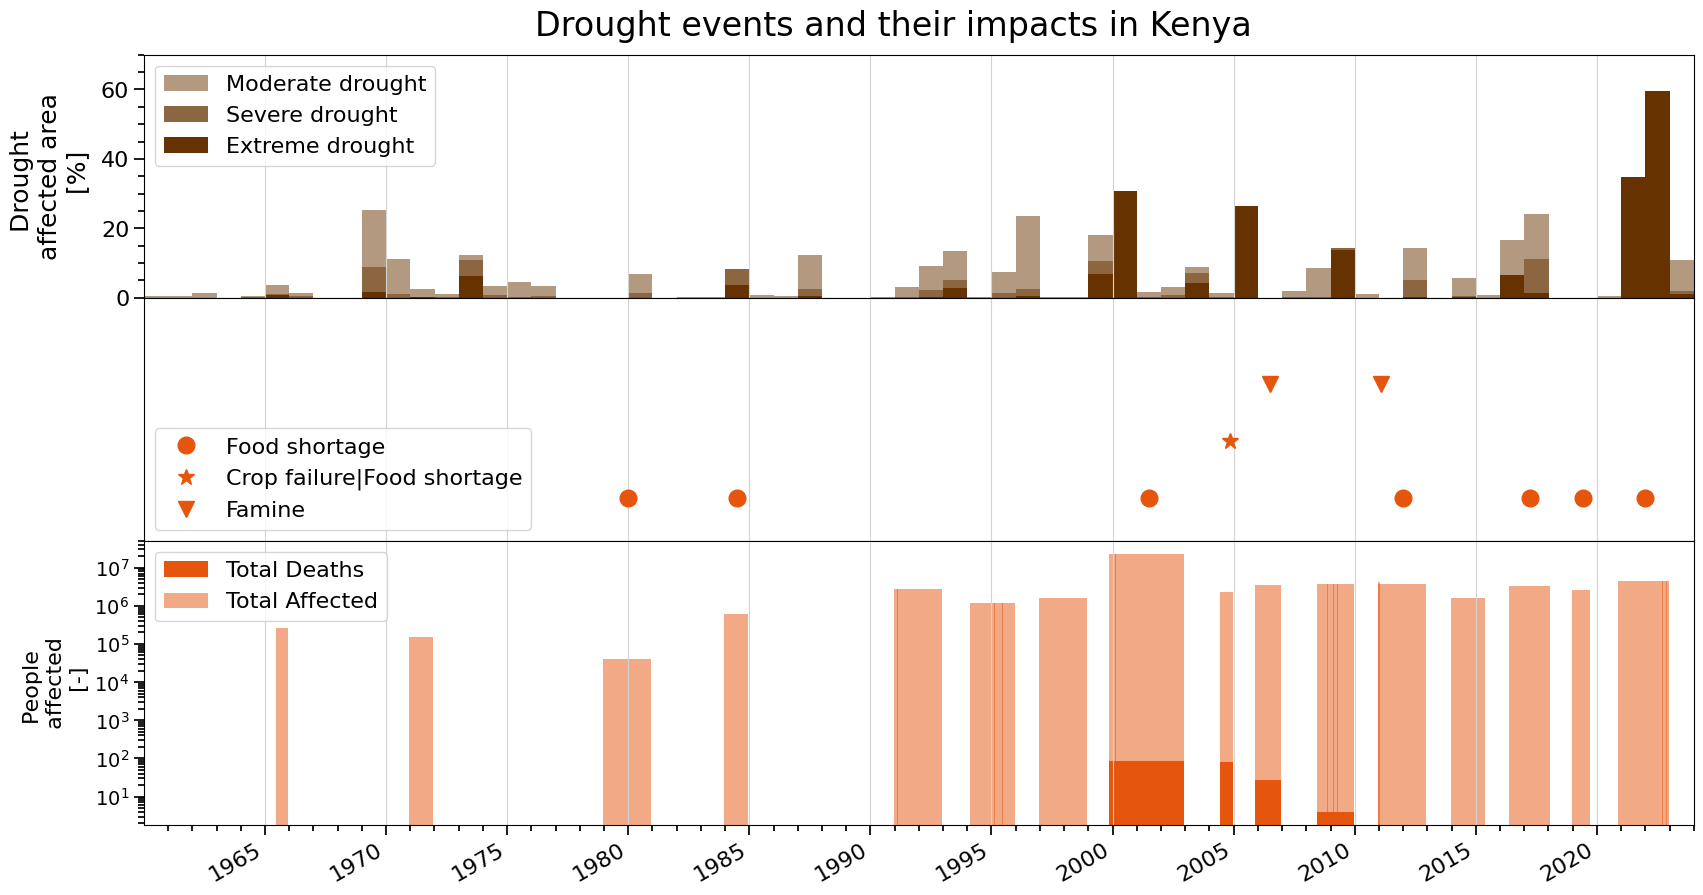

In [62]:
window = 12
toplot_mod = aid_spi[f'w{window}']['moderate'][f'SPI{window}'].iloc[aid_spi[f'w{window}']['moderate'][f'SPI{window}'].index.year >= syyyy]
toplot_sev = aid_spi[f'w{window}']['severe'][f'SPI{window}'].iloc[aid_spi[f'w{window}']['severe'][f'SPI{window}'].index.year >= syyyy]
toplot_ext = aid_spi[f'w{window}']['extreme'][f'SPI{window}'].iloc[aid_spi[f'w{window}']['extreme'][f'SPI{window}'].index.year >= syyyy]
#toplot_mod = aid_spei[f'w{window}']['moderate'][f'SPEI{window}'].iloc[aid_spei[f'w{window}']['moderate'][f'SPEI{window}'].index.year >= syyyy]
#toplot_sev = aid_spei[f'w{window}']['severe'][f'SPEI{window}'].iloc[aid_spei[f'w{window}']['severe'][f'SPEI{window}'].index.year >= syyyy]
#toplot_ext = aid_spei[f'w{window}']['extreme'][f'SPEI{window}'].iloc[aid_spei[f'w{window}']['extreme'][f'SPEI{window}'].index.year >= syyyy]
# shift datetimeindex to get start date of drought
toplot_mod.index = toplot_mod.index.shift(-(window-1), freq="MS") 
toplot_sev.index = toplot_sev.index.shift(-(window-1), freq="MS") 
toplot_ext.index = toplot_ext.index.shift(-(window-1), freq="MS") 

xdate = toplot_mod.index

clevels      = [-1000,-2,-1.5,-1,1,1.5,2,1000]
color_list   = ['#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']
legnames     = ["extremely dry", "severely dry", "moderately dry", "near normal", "moderately wet", "severely wet", "extremely wet"]

# figure
fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, figsize=(20,10), gridspec_kw={'height_ratios': [1.5, 1.5, 1.75]})

fig.suptitle(f"{str(selected_disaster)} events and their impacts in {country_name}", 
             fontsize=24, y=0.925)
fig.subplots_adjust(wspace=0, hspace=0)

# PLOT 1: area in drought based on annual SPI/SPEI drought events
ax0.set_ylabel('Drought \n affected area \n [%]', fontsize=18)
ax0.xaxis.grid(color='lightgray', linestyle='solid') #dashed
ax0.tick_params(axis='both', which='major', labelsize=16)
ax0.bar(xdate, toplot_mod, width=relativedelta.relativedelta(months=window), label='Moderate drought', facecolor=color_list[2], alpha=1, align='edge')
ax0.bar(xdate, toplot_sev, width=relativedelta.relativedelta(months=window), label='Severe drought', facecolor=color_list[1], alpha=1, align='edge')
ax0.bar(xdate, toplot_ext, width=relativedelta.relativedelta(months=window), label='Extreme drought', facecolor=color_list[0], alpha=1, align='edge')
ax0.legend(fontsize=16, loc='upper left')
ax0.get_yaxis().set_label_coords(-0.035,0.5)
ax0.set_ylim(0,70)
ax0.margins(x=0)
# For the minor ticks, use no labels; default NullFormatter.
ax0.yaxis.set_minor_locator(MultipleLocator(5))
ax0.tick_params(which='both', width=1.25)
ax0.tick_params(which='major', length=7)
ax0.tick_params(which='minor', length=4)
# formatting xaxis dates
ax0.xaxis.set_major_locator(matplotdates.YearLocator(base=(5))) 
ax0.xaxis.set_major_formatter(matplotdates.DateFormatter('%Y'))
ax0.xaxis.set_minor_locator(matplotdates.MonthLocator(bymonth=(1)))

# PLOT 2: IMPACT: associated disasters
ax1.set_yticks([])
ax1.set_ylabel('', fontsize=16)
ax1.set_ylim(-0.75,len(dis)+0.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.xaxis.grid(color='lightgray', linestyle='solid') #dashed
for ievent in range(country_events.shape[0]):
    # event dates
    edate = pd.date_range((country_events['start_date'].iloc[ievent]), (country_events['end_date'].iloc[ievent]+relativedelta.relativedelta(months=1, day=1)), freq='MS')
    for ix, idis in enumerate(dis):
        if idis == 'Crop failure':
            continue
        if ( str(country_events['Associated Types'].iloc[ievent]) == idis ):
            ax1.plot(edate[round(len(edate)/2)], dis_loc[ix], color=cols[0], marker=dis_markers[ix], markersize=dis_sizes[ix], linestyle='None', label=idis) # marker in the middle of each event
legend_without_duplicate_labels(ax1, loc='lower left')
ax1.tick_params(which='both', width=1.25)
ax1.tick_params(which='major', length=7)
ax1.margins(x=0)

# PLOT 3: IMPACT - people
ax2.set_ylabel('People \n affected \n [-]', fontsize=16)
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.xaxis.grid(color='lightgray', linestyle='solid') #dashed
socialdf = country_events[['start_date', 'end_date', *social_impacts]]
affected_timeseries = df2ts(socialdf, selected_social_impacts, freq='MS')
selected_social_impacts.reverse() # update order of list, put total affected in background
for ix, iimpact in enumerate(selected_social_impacts):
    if not (country_events[iimpact]==0).all():
        ax2.bar(affected_timeseries['time'], affected_timeseries[iimpact], width=relativedelta.relativedelta(months=1),
                color=cols[0], alpha= 0.5 if iimpact!='Total Deaths' else 1, lw=1, zorder=1, label=iimpact)
ax2.legend(fontsize=16, loc='upper left')
ax2.get_yaxis().set_label_coords(-0.035,0.5)
ax2.tick_params(which='both', width=1.25)
ax2.tick_params(which='major', length=7)
ax2.tick_params(which='minor', length=4)
ax2.margins(x=0)
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right', fontsize=16)    

plt.savefig(f"figures/Figure7_{selected_disaster}_impact_{country_name}.pdf", format="pdf", bbox_inches="tight")

In [65]:
toplot_mod[:]
toplot_sev[:]
toplot_ext[:]

time
1960-01-01 06:00:00     0.000000
1961-01-01 06:00:00     0.000000
1962-01-01 06:00:00     0.000000
1963-01-01 06:00:00     0.000000
1964-01-01 06:00:00     0.000000
                         ...    
2019-01-01 06:00:00     0.000000
2020-01-01 06:00:00     0.000000
2021-01-01 06:00:00    34.639041
2022-01-01 06:00:00    59.396247
2023-01-01 06:00:00     0.956409
Name: SPI12, Length: 64, dtype: float64